In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
import sklearn.metrics
from matplotlib import pyplot
import pandas_profiling

In [2]:
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

In [3]:
bike = pd.read_csv('/Users/jeandre/Desktop/Applied Machine Learning/Post Block Assignemnt 1/SeoulBikeData.csv',encoding='latin1')

### Data quality findings and actions:
- Date will be removed as it has extreme high cardinality and time of year is represented by season.
- Need to encode seasons values since strings are not compatible with the modeling process used. Will use dummy encoding and dropping first column.
- The Amount of rented bikes will need to be binned. Having the model predict a distinct value of 2166 possible combinations is going to lead to poor results. With a maximum of 3556 and minimum of 0 it will be binned into quartiles. This provides a good balance between accuracy and business value.
- Removal of Dew point temperature due to its very high correlation between itself and temperature.
- Removal of "Functioning days" since there is no reason to predict the amount of bikes that will be rented when the rental business is closed.
- Dummy encoding of the holiday variable to make it compatible with the modeling processes used.
- Creation of a new vector based hour system due to the linear time system not representing the closeness of 23 and 1.
- Removal of snowfall and rainfall since 95%+ are zeros.

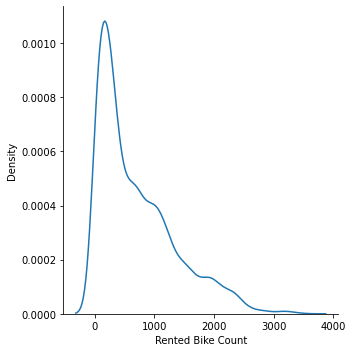

In [4]:
sns.displot(data = bike, x = "Rented Bike Count", kind = "kde" ) # distribution of "average feature"

In [5]:
bike.drop('Dew point temperature(°C)',axis=1,inplace =True)
bike.drop('Functioning Day',axis=1,inplace =True)
bike.drop('Date',axis=1,inplace =True)
bike.drop('Rainfall(mm)',axis=1,inplace =True)
bike.drop('Snowfall (cm)',axis=1,inplace =True)

In [6]:
dummy_season = pd.get_dummies(bike['Seasons'],drop_first=True)
bike.drop('Seasons',axis=1,inplace =True) # no use for this after we have the dummy encoding

dummy_holiday = pd.get_dummies(bike['Holiday'],drop_first=True)
bike.drop('Holiday',axis=1,inplace =True) # no use for this after we have the dummy encoding

In [7]:
#creating new feature based on hours that better represents the ralationhip by converting it from an ordinal linear
# relationship to a circular one. better shows the delta between 23 and 1 for eg.
bike["x"] = np.sin(np.radians(bike["Hour"]*15)) # sin and cos switched so that 0 and 24 are situated at the top.
bike["y"] = np.cos(np.radians(bike["Hour"]*15)) # Thus we have a vector that represents the time in a circular domain.
bike.head(2)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),x,y
0,254,0,-5.2,37,2.2,2000,0.0,0.000000,1.000000
1,204,1,-5.5,38,0.8,2000,0.0,0.258819,0.965926


In [8]:
X = bike[list(bike.columns[2:])]
X = X.merge(dummy_season,left_index=True, right_index=True) # adding in the dummy encodings of seasons
X = X.merge(dummy_holiday,left_index=True, right_index=True) # adding in the dummy encodings of holidays
X.head(2)

,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),x,y,Spring,Summer,Winter,No Holiday
0,-5.2,37,2.2,2000,0.0,0.000000,1.000000,0,0,1,1
1,-5.5,38,0.8,2000,0.0,0.258819,0.965926,0,0,1,1


In [9]:
bike["Rented Bike Count"] = pd.to_numeric(bike["Rented Bike Count"], downcast="float")
Y = bike["Rented Bike Count"]
Y.head(2)

0    254.0
1    204.0
Name: Rented Bike Count, dtype: float32

In [10]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y, test_size = 0.4, random_state = 0)

# KNN

### Description:
KNN is an uncomplicated classification and regression algorithm that assigns the class of an unknown entity based on the class of its k nearest neighbors (k being decided by the implementer of the algorithm). The algorithm takes the unknown entities from the test set and the known entities that it bases its decisions on from the training set.

Below, after several K's tested it was found that k=12 was the best performing value for k.

In [11]:
k=12
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(X_train,Y_train)
K_pred = neigh.predict(X_test)
print("K is =",k)
print("Score = ",neigh.score(X_test,Y_test))

K is = 12
Score =  0.40867017742648526


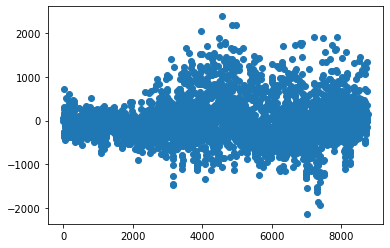

In [12]:
plt.plot(Y_test - K_pred,marker='o',linestyle='')

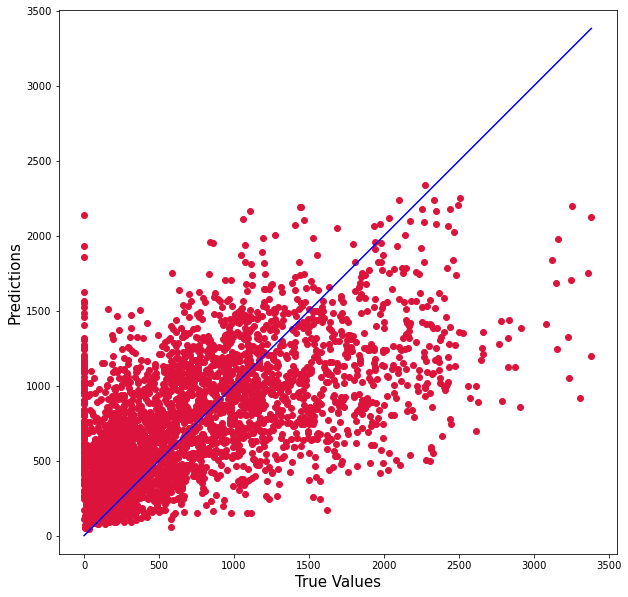

In [13]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test, K_pred, c='crimson')

p1 = max(max(K_pred), max(Y_test))
p2 = min(min(K_pred), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# Decision Tree

### Description:
Decision trees classify unknown entities from the testing set by following a tree where each node describes a decision boundary in the state space. The algorithm follows this tree until it terminates at a node at which point it knows what to classify the unknown entity as. The decision boundaries are learnt from the training set by subdividing each state space recursively untill it reaches maximum homogeneity, thus the tree is overfitted to the training set. In order to further generalise the model the tree is pruned to remove the most overfitting branches and make the model more accurate in a general usecase. In this instance minimal cost complexity is used to prune the tree. 

In [14]:
treeinst = tree.DecisionTreeRegressor(random_state=0)
treeclf = treeinst.fit(X_train, Y_train)
D_pred = treeclf.predict(X_test)
print("Score = ",treeclf.score(X_test,Y_test))

Score =  0.5297513506229128


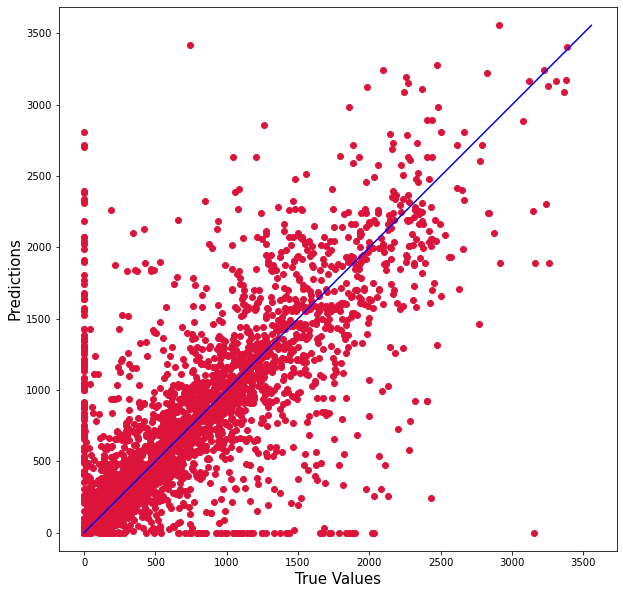

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test, D_pred, c='crimson')

p1 = max(max(D_pred), max(Y_test))
p2 = min(min(D_pred), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

from the two plots of KNN and Decision trees comparing predicted values versus true values it is clear to see that the Decision tree has its values closer to the blue line (representing 1:1 match between predicted and true values). The decision tree also has a much higher $R^2$ score, 0.53 vs 0.41. KNN has much fewer occurrences of predicting a zero when the true value is some other value than the decision tree (seen by the line of zero values at the bottom of the graph) yet both mispredict higher values when the true value is zero. KNN has a trend of underpredicitng the true value.

The decision tree is the better pick for this regression task of predicting bike rentals. There was no pruning of the decision tree in this implementation.